In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os    
from chardet import detect
import re
import scipy as stats
import camelot
from sklearn.linear_model import LinearRegression

def ele_type_per_col(df):
    """
    input: df
    output: returns list of set of datatypes per row, the first element
            is the name of the respective column
    """
    type_list = []
    for i in range(len(df.columns)):
        a = set([type(a) for a in df.iloc[:,i]])
        a = (df.columns[i],*a)
        type_list.append(a)
    return type_list

def get_encoding_type(file):
    """
    checks file type of encoding, returns string with the type
    """
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

def umlaut(string):
    """
    This function replaces replcaces umlaut-code with letter in utf-8. 
    This is useful, when detect function from chardet module does not 
    work.
    dirk.ulbricht@gmail.com, 20.9.2019
    """
    string = re.sub('Ã¼', 'ü',string)
    string = re.sub('ÃŸ', 'ß', string)
    string = re.sub('Ã¶', 'ö', string)
    string = re.sub('Ã¤', 'ä', string)
    return string


def cleaner(x):
    """
    substitutes commas with colons and returns float of it or returns nan
    """
    try:
        result = float(re.sub(',','.',x))
    except:
        result = np.nan
    return result


# Results of the most recent European Elections in Germany (2019). 
Source: https://www.bundeswahlleiter.de/europawahlen/2019/ergebnisse.html (last accessed 2019-07-27).

Contains results for all cities and free regions for all 16 German Laender and aggregated Data for Laender. 

In [3]:
election = pd.read_csv('data\\bundeswahlleiter\\ew19_kerg.csv'
                      ,skiprows=[0,1,3,4]
                      ,delimiter=';')

election.dropna(axis=1, inplace=True, how='all')

# Nr (German "Nummer") is the key, Nr < 1000 indicate states or national levels
election = election[election.Nr.isna()==False]
election.Nr = election.Nr.astype('int32')
election = election[election.Nr>999]
election = election.set_index('Nr')

# conenctrating on cols containing AfD data
AfD_colname=list(election.columns.str.contains('Alternative'))
AfD_colind = np.where(AfD_colname)[0][0]
election = election.iloc[:, [a for a in np.arange(10)]+[AfD_colind, AfD_colind+1]]

# renaming columns
election.columns = ['Gebiet'
              , 'gehört zu'
              , 'Wahlberechtigte 2019'
              , 'Wahlberechtigte 2014'
              , 'Wähler/-innen 2019'
              , 'Wähler/-innen 2014'
              , 'Ungültige 2019'
              , 'Ungültige 2014'
              , 'Gültige 2019'
              , 'Gültige 2014'
              , 'AfD 2019'
              , 'AfD 2014']
election.columns = ['region'
              , 'subregion'
              , 'eligible_voters_19'
              , 'eligible_voters_14'
              , 'voters_19'
              , 'voters_14'
              , 'invalid_19'
              , 'invalid_14'
              , 'valid_19'
              , 'valid_14'
              , 'afd_19'
              , 'afd_14']


#election.index.apply(lambda x: int(x))
election.shape # there are 401 regions
# election.describe().iloc[0].sort_values() # data are complete
election[election.region.str.contains('Kassel')]

,region,subregion,eligible_voters_19,eligible_voters_14,voters_19,voters_14,invalid_19,invalid_14,valid_19,valid_14,afd_19,afd_14
Nr,,,,,,,,,,,,
6611,"Kassel, documenta-Stadt",6.0,140438.0,142751.0,77652.0,57059.0,663.0,592.0,76989.0,56467.0,5747.0,4560.0
6633,Kassel,6.0,188527.0,190823.0,106538.0,78845.0,1478.0,1485.0,105060.0,77360.0,10021.0,7277.0


### Data on Overindebtedness in Germany from Creditreform 
https://www.creditreform.de/aktuelles-wissen/pressemeldungen-fachbeitraege/show/schuldneratlas-deutschland-2018, last retrieved 2019-07-31.

In [4]:
file = 'data\\creditreform\\SchuldnerAtlas2018.csv'
creditreform = pd.read_csv(file, sep=';' ,skiprows=8, decimal=',')

# renaming columns, skipping na lines
creditreform.columns = ['nr', 'region', 'state', 'state_abbrev', '2013', '2014', '2015', '2016', '2017', '2018']
creditreform = creditreform.dropna()

# some state-level information needs to be skipped
creditreform = creditreform[creditreform.state != 'Bundesland']

# Umlaute couldn*t be dealt with using encoding and detect (see functions at top of notebook) therefore:
# correct for wrong reading of German "Umlaute"
creditreform['region'] = creditreform['region'].apply(umlaut)
creditreform['state'] = creditreform['state'].apply(umlaut)

creditreform['2013'] = creditreform['2013'].str.replace(',','.').astype(float)
creditreform['2014'] = creditreform['2014'].str.replace(',','.').astype(float)
creditreform['2015'] = creditreform['2015'].str.replace(',','.').astype(float)
creditreform.shape # There are 401 regions and here are 401 lines
creditreform.head()
creditreform.dtypes

nr               object
region           object
state            object
state_abbrev     object
2013            float64
2014            float64
2015            float64
2016            float64
2017            float64
2018            float64
dtype: object

# Joining election and overindebtedness data

In [5]:
creditreform.set_index('region',inplace=True)
creditreform.rename(index={
    'Aachen, Städteregion': 'Städteregion Aachen',
    'Baden-Baden, Stadtkreis': 'Baden-Baden, Stadt',
    'Düren, Kreis': 'Düren',
    'Freiburg im Breisgau, Stadtkreis': 'Freiburg im Breisgau, Stadt',
    'Heidelberg, Stadtkreis': 'Heidelberg, Stadt',
    'Heilbronn, Stadtkreis': 'Heilbronn, Stadt',
    'Karlsruhe, Stadtkreis': 'Karlsruhe, Stadt',
    'Kleve, Kreis': 'Kleve',
    'Ludwigshafen am Rhein, kreisfr. Stadt': 'Ludwigshafen am Rhein, kreisfreie Stadt',
    'Mannheim, Stadtkreis': 'Mannheim, Universitätsstadt',
    'Mettmann, Kreis': 'Mettmann',
    'Neustadt a.d. Weinstraße, Stadt': 'Neustadt an der Weinstraße, kreisfreie Stadt',
    'Pforzheim, Stadtkreis': 'Pforzheim, Stadt', 
    'Schwabach': 'Schwabach, Stadt',
    'Stuttgart, Stadtkreis': 'Stuttgart, Landeshauptstadt', 
    'Ulm, Stadtkreis': 'Ulm, Universitätsstadt',
    'Viersen, Kreis': 'Viersen',
    'Wesel, Kreis': 'Wesel',
    'Deutschland': 'Bundesgebiet'
},inplace=True)
creditreform.reset_index(inplace=True)    
df = election.merge(creditreform, how='outer', left_on='region', right_on='region')#, indicator=True

# skip national level 
df_state = df[df['subregion']==99]
df = df[df['subregion']!=99]

# the following tables where used to find mismatches
    #el_no_match = df[df['_merge']=='left_only']
    #print(el_no_match[el_no_match.subregion!=99.0])
    #df[df._merge=='right_only']
df.head()
df.shape
df.dtypes

region                 object
subregion             float64
eligible_voters_19    float64
eligible_voters_14    float64
voters_19             float64
voters_14             float64
invalid_19            float64
invalid_14            float64
valid_19              float64
valid_14              float64
afd_19                float64
afd_14                float64
nr                     object
state                  object
state_abbrev           object
2013                  float64
2014                  float64
2015                  float64
2016                  float64
2017                  float64
2018                  float64
dtype: object

# Adding some columns
- relative share of votes for AfD per voters 19 and 14(afd_vot19 and afd_vot14)
- relative share of votes for AfD per eligable_voters (afd_eli19)
- relative share of votes for Afd per valid votes cast (afd_val19)
- change in share of overindebted adults from 2013 to 2018 in % (ove18_13)
- change in share of AfD between 19 and 14 (vot19_14)

In [6]:
df.columns

Index(['region', 'subregion', 'eligible_voters_19', 'eligible_voters_14',
       'voters_19', 'voters_14', 'invalid_19', 'invalid_14', 'valid_19',
       'valid_14', 'afd_19', 'afd_14', 'nr', 'state', 'state_abbrev', '2013',
       '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [7]:
df['afd_vot19']= df.afd_19 / df.voters_19*100
df['afd_eli19']= df.afd_19 / df.eligible_voters_19*100
# Thats the statistic reported on, as it reflects outcome
df['afd_val19']= df.afd_19 / df.valid_19*100
df['afd_val14']= df.afd_14 / df.valid_14*100
df['ove18_13']=df['2018']-df['2013']
df['vot19_14']=df.afd_val19-df.afd_val14
df['part']='blue'
df.loc[df['subregion']>=12,'part']='red'
df.tail()
df.describe().iloc[0]

subregion             401.0
eligible_voters_19    401.0
eligible_voters_14    401.0
voters_19             401.0
voters_14             401.0
invalid_19            401.0
invalid_14            401.0
valid_19              401.0
valid_14              401.0
afd_19                401.0
afd_14                401.0
2013                  401.0
2014                  401.0
2015                  401.0
2016                  401.0
2017                  401.0
2018                  401.0
afd_vot19             401.0
afd_eli19             401.0
afd_val19             401.0
afd_val14             401.0
ove18_13              401.0
vot19_14              401.0
Name: count, dtype: float64

<IPython.core.display.Javascript object>


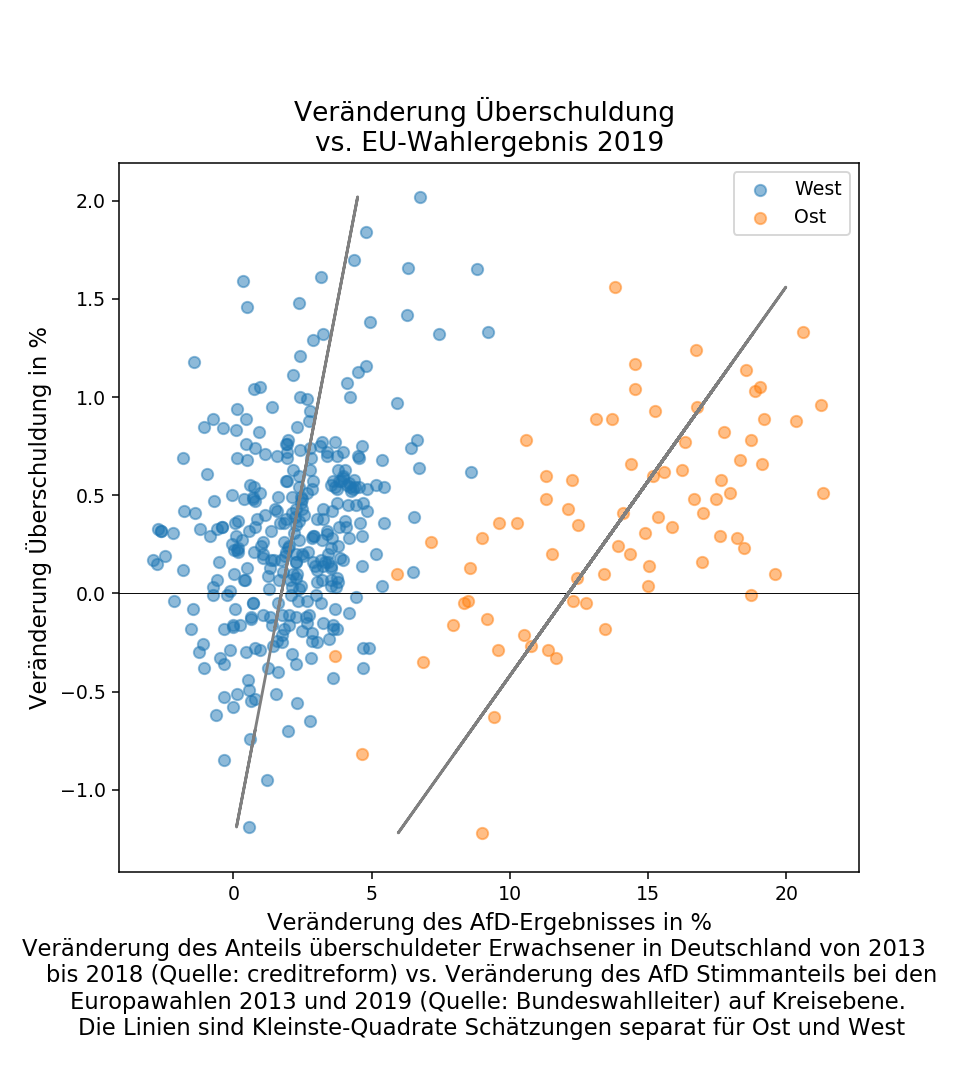

In [8]:
f, (ax2) = plt.subplots(1, 1)#, sharey=True)
#f.figsize=(6,4)
plt.subplots_adjust(top=0.85,bottom=0.2)
language = 'german'# 'eng' or german
if language == 'eng':
    title_left = 'Overindebtedness 2019\nvs. Voteshare'
    ylabel_left = 'Overindebtedness'
    xlabel_left = 'AfD result in %'
    title_right = 'Change in Overindebtedness\nvs. Voteshare'
    ylabel_right = 'Change of Overindebtedness'
    xlabel_right = 'Change of AfD result in %'
    figname = 'figures\\Overindebtedness and AfD-electoral results.png'
    txt = """Change of percentage of overindebted adults in Germany from 2013 to 2018 
    (source: creditreform) against change in AfD's electoral results European 
    Elections 2014 and 2019 in percent (source: Bundeswahlleiter)"""
if language == 'german':
    title_left = 'Überschuldung \nvs. EU-Wahlergebnis 2019'
    ylabel_left = 'Überschuldung'
    xlabel_left = 'AfD-Ergebnis in %'
    title_right = 'Veränderung Überschuldung \nvs. EU-Wahlergebnis 2019'
    ylabel_right = 'Veränderung Überschuldung in %'
    xlabel_right = 'Veränderung des AfD-Ergebnisses in %'
    figname = 'figures\\Überschuldung und AfD Wahlergebnis Europawahl 2019.png'
    txt = """Veränderung des Anteils überschuldeter Erwachsener in Deutschland von 2013 
    bis 2018 (Quelle: creditreform) vs. Veränderung des AfD Stimmanteils bei den
    Europawahlen 2013 und 2019 (Quelle: Bundeswahlleiter) auf Kreisebene. 
    Die Linien sind Kleinste-Quadrate Schätzungen separat für Ost und West"""

#ax1.set_title(title_left)
#ax1.scatter( df.afd_val19,df['2018'],color='black',alpha=0.5)
#ax1.set_ylabel(ylabel_left)
#ax1.set_xlabel(xlabel_left)
fontsize_labels = 12

ax2.set_title(title_right, fontsize = (fontsize_labels+2))
ax2.scatter(df[df.part=='blue'].vot19_14,
            df[df.part=='blue'].ove18_13, label=('West'),alpha=0.5 )
ax2.scatter(df[df.part=='red'].vot19_14, 
            df[df.part=='red'].ove18_13, label=('Ost'),alpha=0.5 )
ax2.axhline(color='black',lw=0.5)
ax2.set_ylabel(ylabel_right, fontsize=fontsize_labels)
ax2.set_xlabel(xlabel_right, fontsize=fontsize_labels)
ax2.legend()
#plt.subplots_adjust(wspace=0.4)

f.text(.5, .05, txt, ha='center', fontsize=fontsize_labels)

# resize the figure to match the aspect ratio of the Axes    
f.set_size_inches(7, 8, forward=True)


# estimate slopes
y_west = df[df.part=='blue'].vot19_14
y_east = df[df.part=='red'].vot19_14
x_west = np.array(df[df.part=='blue'].ove18_13.values).reshape(-1, 1)
x_east = np.array(df[df.part=='red'].ove18_13.values).reshape(-1, 1)

reg_west = LinearRegression().fit(x_west, y_west)


y_hat_west = reg_west.predict(x_west)

ax2.plot(y_hat_west,x_west,color='grey')

reg_east = LinearRegression().fit(x_east, y_east)

y_hat_east = reg_east.predict(x_east)

ax2.plot(y_hat_east,x_east,color='grey')

In [9]:
print('Score East-Germany: ',reg_east.score(x_east, y_east))
print('Score West-Germany: ',reg_west.score(x_west, y_west))

Score East-Germany:  0.3831140133080897
Score West-Germany:  0.10402299668939365


## Structural data as provided by the Federal Statistical Office of Germany (Statistisches Bundesamt)

Here, we make use of the data provided by the Federal Returning Officer (Bundeswahlleiter) for the 2014 European elections https://www.bundeswahlleiter.de/en/europawahlen/2014/strukturdaten.html and the 2019 European elections https://www.bundeswahlleiter.de/en/europawahlen/2019/strukturdaten.html.

In [10]:
file='data\\bundeswahlleiter\\ew19_strukturdaten.csv'
# the file wouldn't read with the standard settings, therefore 
# get file encoding type and apply to read_csv

encoding = get_encoding_type(file)

struk19 = pd.read_csv(file,skiprows=range(8)
                      , encoding=encoding
                      , delimiter=';'
                      , decimal=',')
# delete "comments" ("Fußnoten")
col_sel = np.invert(['Fußnoten' in a for a in struk19.columns])
struk19 = struk19.iloc[:,col_sel]

# some of the variables have been read as obj as read_csv does 
# not handle % AND comma decimal correctly

# getting the respective columnnames as list
obj_bool = struk19.dtypes == 'object'
obj_coln = list(struk19.columns.values[obj_bool])
obj_l_ind = [a for a in range(len(struk19.columns)) if struk19.columns.values[a] in obj_coln]

# the first 2 columns are text data that do not need to be converted
# therefore [2:]
obj_coln = obj_coln[2:]

for i in obj_l_ind[2:]:
    struk19.iloc[:,i] = struk19.iloc[:,i].apply(cleaner)
struk19.iloc[:,obj_l_ind[2:]].describe()

,Zu- (+) bzw. Abnahme (-) der Bevölkerung 2017 - Geburtensaldo (je 1000 Einwohner),Zu- (+) bzw. Abnahme (-) der Bevölkerung 2017 - Wanderungssaldo (je 1000 Einwohner),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - insgesamt (je 1000 Einwohner),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit offenem Schutzstatus (%),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit anerkanntem Schutzstatus (%),Schutzsuchende gemäß Ausländerzentralregister am 31.12.2017 - mit abgelehntem Schutzstatus (%),Absolventen/Abgänger beruflicher Schulen 2017 (je 1000 Einwohner),Absolventen/Abgänger allgemeinbildender Schulen 2017 - mit allgemeiner und Fachhochschulreife (%),"Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Land- und Forstwirtschaft, Fischerei (%)",Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Produzierendes Gewerbe (%),"Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Handel, Gastgewerbe, Verkehr (%)",Sozialversicherungspflichtig Beschäftigte am 30.06.2018 - Öffentliche und private Dienstleister (%)
count,435.000000,441.000000,436.000000,436.000000,436.000000,436.000000,438.000000,440.000000,426.000000,434.000000,440.000000,436.000000
mean,-2.745977,5.102721,18.976835,22.200459,66.892661,10.906422,3.487443,32.984318,1.149765,32.042857,22.368864,16.467890
std,2.690982,4.149714,9.244607,9.446826,12.804462,5.544918,2.429341,8.413927,1.228280,10.384764,4.453926,6.922841
min,-9.700000,-14.000000,2.100000,2.700000,20.000000,1.500000,0.100000,11.100000,0.000000,7.600000,10.200000,6.400000
25%,-4.400000,2.700000,12.600000,15.775000,60.000000,7.200000,1.900000,27.100000,0.300000,24.425000,19.375000,11.400000
50%,-2.600000,5.000000,18.050000,21.350000,68.100000,9.850000,2.950000,32.400000,0.800000,31.550000,21.900000,14.550000
75%,-1.000000,7.300000,23.400000,27.200000,74.575000,13.300000,4.375000,38.400000,1.700000,40.175000,24.725000,19.525000
max,4.300000,21.300000,124.300000,57.800000,94.800000,33.500000,14.900000,57.900000,9.300000,62.900000,48.300000,44.200000


In [11]:
file='data\\bundeswahlleiter\\ew14_strukturdaten.csv'
struk14 = pd.read_csv(file,skiprows=[0,1,2,3,5]
                      , encoding='Windows-1252'
                      , error_bad_lines=False
                      ,delimiter=';'
                      ,decimal=',')
# skip "comments"-column
col_sel = np.invert(['Bemerkungen' in a for a in struk14.columns])
struk14 = struk14.iloc[:,col_sel]

# some columns are not read as floats
obj_bool = struk14.dtypes == 'object'
obj_coln = list(struk14.columns.values[obj_bool])
obj_l_ind = [a for a in range(len(struk14.columns)) if struk14.columns.values[a] in obj_coln]
#struk14.columns.values[obj_l_ind]
struk14[obj_coln].head()

obj_coln = obj_coln[2:]

for i in obj_l_ind[2:]:
    struk14.iloc[:,i] = struk14.iloc[:,i].apply(cleaner)
struk14.describe()


#struk14.iloc[:,obj_coln]
struk14[obj_coln].describe()

,Zu- (+) bzw. Abnahme (-) der Bevölkerung 2012 - Wanderungssaldo (je 1000 Einwohner),Allgemein bildendes Schulwesen: Absolventen/Abgänger nach dem Abschluss 2012 - mit allgemeiner Hochschulreife (%),Insolvenzverfahren 2012 - Beschäftigte (je 1000 Einwohner)
count,442.000000,441.000000,438.000000
mean,3.407466,34.091156,2.135845
std,4.754019,9.795437,7.414718
min,-11.000000,11.800000,0.100000
25%,0.100000,26.600000,0.725000
50%,3.450000,33.700000,1.300000
75%,6.300000,40.500000,2.200000
max,20.000000,65.700000,147.700000


In [12]:
# exporting columns for semi-automatic translation (using deepl.com) and comparison with 
# corresponding dataset 2014
pd.DataFrame(struk14.columns).to_excel('data\\bundeswahlleiter\\struk14_cols.xlsx')
pd.DataFrame(struk19.columns).to_excel('data\\bundeswahlleiter\\struk19_cols.xlsx')

In [13]:
# This cell reads the manually checked headings for 2019 and 2014 back in. It contains translations (transl)
# of the headings and variable names and a Comment line indicating if 2019 and 2014 values are comparable or 
# not
struk_ov = pd.read_excel('data\\bundeswahlleiter\\struk19_vs_struk14.xlsx')
struk_ov.head()

,desc_2019,desc_2014,transl_2019,transl_2014,variable_2019,variable_2014,Comment
0,Land,Land,region,region,region_2019,region_2014,comparable
1,Kreis,Kreis,county,county,county_2019,county_2014,comparable
2,Name,Name,name,name,name_2019,name_2014,comparable
3,Gemeinden am 31.12.2017 (Anzahl),Gemeinden am 31.12.2013 (Anzahl),Municipalities on 31.12.2017 (number),Municipalities on 31.12.2013 (number),municipalities_2017,municipalities_2013,comparable
4,Fläche am 31.12.2017 (km²),Fläche am 31.12.2012 (km²),Area on 31.12.2017 (km²),Area on 31.12.2012 (km²),area_2017,area_2012,comparable


In [14]:
# Renaming the variables for ease of typing
rn_19 = dict()
for i in range(len(struk_ov)):
    old_name = struk_ov.desc_2019.iloc[i]
    new_name = struk_ov.variable_2019.iloc[i]
    #print(old_name)
    if isinstance(old_name,str) and (old_name in struk19.columns):
        rn_19.update({old_name: new_name})
type(struk19)
[a in struk19.columns for a in struk_ov.desc_2019]
struk19 = struk19.rename(columns=rn_19)

rn_14 = dict()
for i in range(len(struk_ov)):
    old_name = struk_ov.desc_2014.iloc[i]
    new_name = struk_ov.variable_2014.iloc[i]
    #print(old_name)
    if isinstance(old_name,str) and (old_name in struk14.columns):
        rn_14.update({old_name: new_name})

struk14 = struk14.rename(columns=rn_14)

In [15]:
struk19.head()

,region_2019,county_2019,name_2019,municipalities_2017,area_2017,population_2017,germans_2017,foreigners_2017,population_density_2017,birth_balance_2017,...,empl_service_2018,empl_oth_service_2018,hartz_total_2018,hartz_no_empl_2018,hartz_foreign_2018,unempl_total_2019,unempl_male_2019,unempl_female_2019,unempl_15_19_2019,unempl_55_64_2019
0,Schleswig-Holstein,1001,"Flensburg, Stadt",1,56.7,88.5,76.8,13.3,1560.4,-1.7,...,20.1,38.7,137.9,25.6,29.7,8.2,9.0,7.2,5.1,7.7
1,Schleswig-Holstein,1002,"Kiel, Landeshauptstadt",1,118.7,247.9,220.0,11.3,2089.7,0.1,...,26.2,38.7,140.4,26.8,33.6,7.9,8.9,6.9,4.7,8.2
2,Schleswig-Holstein,1003,"Lübeck, Hansestadt",1,214.2,216.3,195.4,9.7,1009.9,-3.6,...,22.9,28.9,122.5,26.6,27.0,7.8,8.5,7.0,5.0,7.6
3,Schleswig-Holstein,1004,"Neumünster, Stadt",1,71.7,79.3,70.6,11.0,1107.1,-5.4,...,20.0,26.2,123.1,26.5,25.7,8.3,8.5,7.9,6.3,7.5
4,Schleswig-Holstein,1051,Dithmarschen,116,1428.2,133.4,126.0,5.6,93.4,-5.3,...,11.4,32.0,87.8,27.4,23.0,6.4,6.7,6.0,4.9,6.3


In [16]:
# creating new columns containing changes
comparable = struk_ov.iloc[6:,]
comparable = comparable[comparable['Comment']=='comparable']
for i in range(len(comparable)):
    #print(i)
    var19 = comparable.variable_2019.iloc[i]
    var14 = comparable.variable_2014.iloc[i]
    var_ch = var19+'_'+var14[-4:]
    struk19[var_ch] = struk19[var19] - struk14[var14]
struk19[var19].dtype
struk14[var14].dtype 
struk19.dtypes

region_2019                                                                                           object
county_2019                                                                                            int64
name_2019                                                                                             object
municipalities_2017                                                                                    int64
area_2017                                                                                            float64
population_2017                                                                                      float64
germans_2017                                                                                         float64
foreigners_2017                                                                                      float64
population_density_2017                                                                              float64
birth_balance_2017 

In [17]:
# create df_new, merge and check if everything is fine
df_new = df.merge(struk19, left_on='region',right_on='name_2019', how='left')
# some regions may not  get merged
df_new.describe().iloc[0,:].sort_values().head()

empl_agr_2018           375.0
empl_agr_2018_2012      375.0
empl_manuf_2018         381.0
empl_manuf_2018_2012    381.0
birth_balance_2017      382.0
Name: count, dtype: float64

In [18]:
reg_not_merged = struk19.name_2019.iloc[[a not in df_new.region.values for a in struk19.name_2019]]
reg_nm_only_cities = reg_not_merged.iloc[[', Stadt' in a for a in reg_not_merged]]
# here, "Kreis"stadt is missing to match the corresponding region in df
reg_nm_oc_short = reg_nm_only_cities.str.split(',',expand=True).iloc[:,0]
reg_nm_oc_short

155                       Koblenz
166                         Trier
171           Frankenthal (Pfalz)
172                Kaiserslautern
173           Landau in der Pfalz
174         Ludwigshafen am Rhein
175                         Mainz
176    Neustadt an der Weinstraße
177                     Pirmasens
178                        Speyer
179                         Worms
180                   Zweibrücken
Name: 0, dtype: object

In [19]:
# "kreisfreie" is the problem
df.region[df.region.str.contains('Trier')]

153    Trier, kreisfreie Stadt
157             Trier-Saarburg
Name: region, dtype: object

In [20]:
df.region.str.replace(', Stadt', ', kreisfreie Stadt')
kreisfreie = df.region[df.region.str.contains(', kreisfreie Stadt')]
kreisfreie = kreisfreie.str.replace(', kreisfreie Stadt', ', Stadt')
df.region[df.region.str.contains(', kreisfreie Stadt')]= kreisfreie.copy()
df.region[df.region.str.contains(', kreisfreie Stadt')]

C:\Users\dirku\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Series([], Name: region, dtype: object)

In [21]:
df.region[df.region.str.contains(', krStadt')]

Series([], Name: region, dtype: object)

In [22]:
#for i in range(len(reg_nm_oc_short)):
i=0
reg_nm_only_cities.iloc[0]
struk19.name_2019[struk19.name_2019==reg_nm_only_cities.iloc[i]]=df.region[df.region.str.contains(reg_nm_oc_short.iloc[i])]

C:\Users\dirku\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
df.subregion.apply(lambda x: np.isnan(x))
df.describe().iloc[0,:].sort_values()
#df[df.insolvencies_2017.apply(lambda x: np.isnan(x))]

subregion             401.0
afd_val14             401.0
afd_val19             401.0
afd_eli19             401.0
afd_vot19             401.0
2018                  401.0
2017                  401.0
2016                  401.0
2015                  401.0
2014                  401.0
ove18_13              401.0
2013                  401.0
afd_19                401.0
valid_14              401.0
valid_19              401.0
invalid_14            401.0
invalid_19            401.0
voters_14             401.0
voters_19             401.0
eligible_voters_14    401.0
eligible_voters_19    401.0
afd_14                401.0
vot19_14              401.0
Name: count, dtype: float64